Shows how to load the phi maps, compute mean field  and get unbiased power spectra 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as pl
import numpy as np
import healpy as hp 
from plancklens import utils
from plancklens import qresp
from scipy.interpolate import UnivariateSpline as spl
from os.path import join as opj 
from lensitbiases import n1_fft
from lenspec import iterbiasesN0N1

In [3]:
import sys
sys.version

'3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) \n[GCC 9.4.0]'

In [4]:

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['font.size'] = 20
# mpl.rcParams['figure.figsize'] = 6.4, 4.8
mpl.rcParams['figure.figsize'] = 8.5, 5.5

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('legend', fontsize=15)
mpl.rcParams['errorbar.capsize'] = 4

In [5]:
def w(ell):
    return (ell*(ell+1))**2 / 2 / np.pi * 1e7

def p2k(lmax):
    return 0.5 * np.arange(lmax + 1) * np.arange(1, lmax + 2, dtype=float)

In [6]:

# Import param file
module_path = os.path.abspath(os.path.join('../params'))
if module_path not in sys.path:
    sys.path.append(module_path)

import param_chwide_qe_lminB200_v2 as param_file


Using lenspyx alm2map


In [7]:
# Import sims library 

module_path = os.path.abspath(os.path.join('../../20231018_signal_cmb'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import unlensed_ffp10

In [8]:
qlms_dd = param_file.qlms_dd

In [9]:
sims = param_file.sims

In [10]:
cmb_unl= unlensed_ffp10.cmb_unl_ffp10()

Input aberration power 2.126e-06


I have computed the fiducial response, as well as the effective response, which is given as the average over the 500 simulations:

$$ R_L^{\rm eff} = \left< \frac{C_L^{\phi^{QE}, \phi^{in}}}{C_L^{\phi^{in}, \phi^{in}} }\right> $$


As shown in the plot below, there is a ~5 percent offset between the fiducial response and the effective response. 
As I baseline am using the effective normalisation.

In [11]:
resp_eff = np.loadtxt('/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v2/resp_qe_effective.txt').T[1]

resp_fid = np.loadtxt('/global/cfs/cdirs/cmbs4xlb/v1/lensingrec/chwide_qe_v2/resp_qe.txt').T[1]


Text(0, 0.5, '$R^{\\rm fid} / R^{\\rm eff}$')

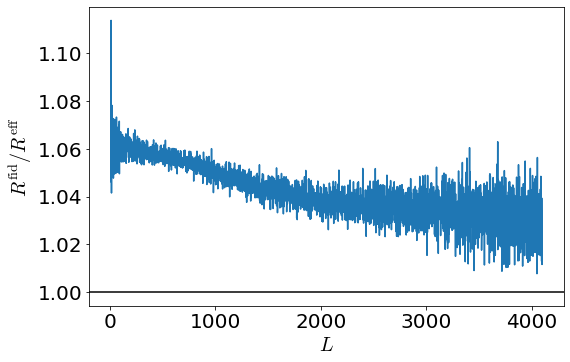

In [12]:
lmax = 4096
ls = np.arange(10, lmax+1)
pl.plot(ls, resp_fid[ls]/resp_eff[ls])

pl.axhline(y=1, c='k')
pl.xlabel('$L$')
pl.ylabel(r'$R^{\rm fid} / R^{\rm eff}$')

The phi maps I provide are normalised either with the fiducial reponse or with the effective response. 


In [13]:
savedir = '/global/cfs/cdirs/cmbs4xlb/v1/lensingrec'
tag = 'chwide_qe_v2'

fn = lambda resp, idx: os.path.join(savedir, tag, f'plm_{resp}_p_p_{idx:04}.fits')
fn_N0 = lambda resp, idx: os.path.join(savedir, tag, f'Nlzero_semianalytic_{resp}_{idx:04}.txt')

Let us use the first simulation as a mock data map.
I also provide the semi-analytical N0, which is realisation dependant.

In [14]:
resp = resp_eff
r = 'reff'
# resp = resp_fid
# r = 'rfid' 
idx = 0 
plm00 = hp.read_alm(fn(r, idx))
N0 = np.loadtxt(fn_N0(r, idx)).T[1]

plm_in = utils.alm_copy(cmb_unl.get_sim_plm(idx), lmax=hp.Alm.getlmax(np.size(plm00)))



For unbiased lensing map, one needs to subtract the mean field. This mean field can be estimate as an average from a subset of the simulations. 


In [15]:
# Mean field estimate
mcsims = np.arange(100, 200)
plm_mf1 = np.zeros_like(plm00)
plm_mf2 = np.zeros_like(plm00)

for idx in mcsims[::2]:
    print(idx)
    plm_mf1+= hp.read_alm(fn(r, idx))
plm_mf1 /= np.size(mcsims[::2])

for idx in mcsims[1::2]:
    print(idx)
    plm_mf2+= hp.read_alm(fn(r, idx))
plm_mf2 /= np.size(mcsims[::2])


100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
144
146
148
150
152
154
156
158
160
162
164
166
168
170
172
174
176
178
180
182
184
186
188
190
192
194
196
198
101
103
105
107
109
111
113
115
117
119
121
123
125
127
129
131
133
135
137
139
141
143
145
147
149
151
153
155
157
159
161
163
165
167
169
171
173
175
177
179
181
183
185
187
189
191
193
195
197
199


We estimate here the N1 bias 

In [16]:
k = 'p_p'

cls_noise_fid = {
    'tt': (param_file.nlev_t / 180 / 60 * np.pi) ** 2 * utils.cli(param_file.transf_tlm ** 2),
    'ee': (param_file.nlev_p / 180 / 60 * np.pi) ** 2 * utils.cli(param_file.transf_elm ** 2),
    'bb': (param_file.nlev_p / 180 / 60 * np.pi) ** 2 * utils.cli(param_file.transf_blm ** 2),
}

fals, dat_cls, cls_w, cls_f = iterbiasesN0N1.get_fals(k, param_file.cls_weight, param_file.cls_grad, cls_noise_fid, cls_noise_fid, lmin_ivf=param_file.lmin_elm, lmax_ivf=param_file.lmax_ivf)


In [17]:
lmax_qlm = 4000
n1lib = n1_fft.n1_fft(fals, cls_w, cls_f, np.copy(param_file.cls_unl['pp']), lminbox=50, lmaxbox=5000, k2l=None)
n1_Ls = np.arange(50, (lmax_qlm // 50) * 50  + 50, 50)

n1 = np.array([n1lib.get_n1(k, L, do_n1mat=False) for L in n1_Ls])
N1 = spl(n1_Ls, n1_Ls ** 2 * (n1_Ls * 1. + 1) ** 2 * n1 / resp[n1_Ls] ** 2, k=2, s=0, ext='zeros')(np.arange(lmax_qlm+1))
N1 *= utils.cli(np.arange(lmax_qlm + 1) ** 2 * np.arange(1, lmax_qlm + 2, dtype=float) ** 2)

Text(0, 0.5, '$ 10^7 L(L+1)^2 / 2\\pi C_L^{\\phi\\phi}$')

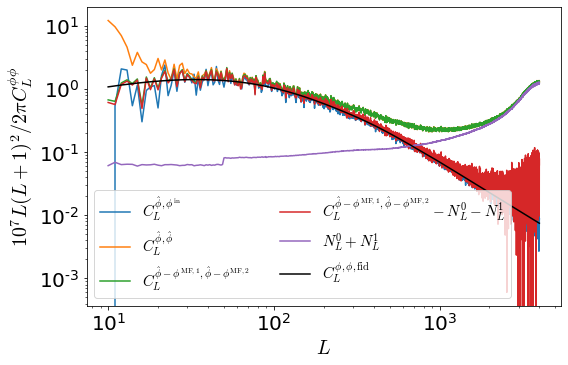

In [18]:
lmax = 4000
ls = np.arange(10, lmax+1)
fsky = np.mean(param_file.ivfs.get_fmask())


pl.plot(ls, w(ls)*hp.alm2cl(plm00, plm_in, lmax_out=lmax)[ls]/fsky, label=r'$C_L^{\hat \phi, \phi^{\rm in}}$')
pl.plot(ls, w(ls)*hp.alm2cl(plm00, plm00, lmax_out=lmax)[ls]/fsky, label=r'$C_L^{\hat \phi, \hat \phi}$')
pl.plot(ls, w(ls)*hp.alm2cl(plm00-plm_mf1, plm00-plm_mf2, lmax_out=lmax)[ls]/fsky, label=r'$C_L^{\hat \phi -\phi^{\rm MF, 1}, \hat \phi-\phi^{\rm MF, 2}}$')
pl.plot(ls, w(ls)*(hp.alm2cl(plm00-plm_mf1, plm00-plm_mf2, lmax_out=lmax)[ls]/fsky - N0[ls] - N1[ls]), label=r'$C_L^{\hat \phi -\phi^{\rm MF, 1}, \hat \phi-\phi^{\rm MF, 2}} - N_L^0 - N_L^1 $')


# pl.plot(ls, w(ls)*hp.alm2cl(plm_mf1, plm_mf2, lmax_out=lmax)[ls]/fsky, label=r'$C_L^{\phi^{\rm MF, 1},\phi^{\rm MF, 2}}$')


pl.plot(ls, w(ls)*(N0[ls] + N1[ls]), label='$N_L^0 + N_L^1$')
pl.plot(ls, w(ls)*param_file.cls_unl['pp'][ls], c='k', label=r"$C_L^{\phi, \phi, \rm fid}$")


pl.loglog()

pl.legend(fontsize=15, ncol=2, loc=3)

pl.xlabel(r'$L$')
pl.ylabel(r'$ 10^7 L(L+1)^2 / 2\pi C_L^{\phi\phi}$')

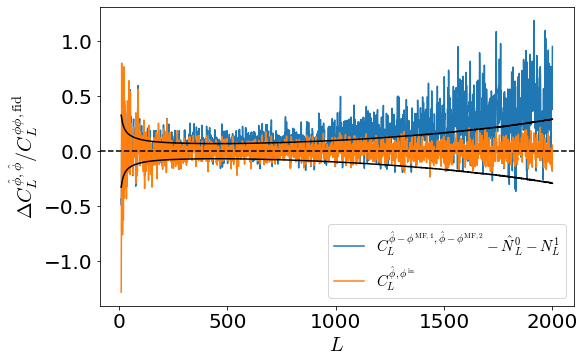

In [19]:
# Lensing power spectrum residual
lmax = 2000
ls = np.arange(10, lmax+1)

cov = utils.cli(2*np.arange(lmax+1)*fsky) * (param_file.cls_unl['pp'][:lmax+1]+N0[:lmax+1]+N1[:lmax+1])**2

# pl.plot(ls, (hp.alm2cl(plm00, plm00, lmax_out=lmax)[ls]/fsky - N0[ls]-N1[ls])*utils.cli(param_file.cls_unl['pp'][ls])-1, label=r'$C_L^{\hat \phi, \hat \phi} - {\hat N}^0_L - N^1_L $')

pl.plot(ls, (hp.alm2cl(plm00-plm_mf1, plm00-plm_mf2, lmax_out=lmax)[ls]/fsky - N0[ls]-N1[ls])*utils.cli(param_file.cls_unl['pp'][ls])-1, label=r'$C_L^{\hat \phi -\phi^{\rm MF, 1}, \hat \phi-\phi^{\rm MF, 2}} - {\hat N}^0_L - N^1_L $')

pl.plot(ls, (hp.alm2cl(plm00, plm_in, lmax_out=lmax)[ls]/fsky )*utils.cli(param_file.cls_unl['pp'][ls])-1, label=r'$C_L^{\hat \phi, \phi^{\rm in}} $')

pl.plot(ls, np.sqrt(cov)[ls]*utils.cli(param_file.cls_unl['pp'][ls]), c='k')
pl.plot(ls, -np.sqrt(cov)[ls]*utils.cli(param_file.cls_unl['pp'][ls]), c='k')

pl.axhline(y=0, c='k', ls='--')

pl.xlabel('$L$')
pl.ylabel(r'$\Delta C_L^{\hat \phi, \hat \phi} / C_L^{\phi\phi, \rm fid}$')
pl.legend()